### List of dependencies
- networkx
- pandas
- numpy
- matplotlib
- community : you can download it [here](https://bitbucket.org/taynaud/python-louvain/get/6a3696fdce57.zip), then just do  : `sudo python3 setup.py install`
 

In [123]:
import pandas as pd
import numpy as np
import community

import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import random
import community
%matplotlib inline

In [124]:
df = pd.read_csv("../data/dataset.CSV", sep=";")

In [125]:
df.describe()

,female_id,male_id,date,female_grade,anal,oral,kiss
count,50632.000000,50632.000000,50632.000000,50632.000000,50632.000000,50632.000000,50632.000000
mean,6674.964074,6497.960045,1561.542878,0.742692,0.300758,0.665192,0.629957
std,4599.308794,4544.051880,444.996668,0.604601,0.817198,0.696622,0.696743
min,0.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2813.000000,2422.250000,1238.000000,1.000000,0.000000,1.000000,1.000000
50%,6235.000000,5766.000000,1617.000000,1.000000,1.000000,1.000000,1.000000
75%,10496.000000,10111.250000,1933.000000,1.000000,1.000000,1.000000,1.000000
max,16728.000000,16729.000000,2232.000000,1.000000,1.000000,1.000000,1.000000


### We add an offset to male id in order to not have the same ids in male and female 

In [126]:
offset_male_id = max(df["female_id"]) + 10000
df["male_id"] = df["male_id"] + offset_male_id

### Ensure that values are sorted by ascending date 

In [127]:
df = df.sort_values("date")

### Let's create the graph, we are going to use Multi Graph because we may have multiple edges between the same escort and client

In [128]:
G = nx.MultiGraph()

In [129]:
list_male_id = df["male_id"].unique()
list_female_id = df["female_id"].unique()


### Be sure that there is no intersection between ids

In [130]:
len(set(list_male_id).intersection(set(list_female_id)))

0

In [131]:
print(len(list_male_id), " different clients")

10106  different clients


In [132]:
print(len(list_female_id), " different escort")

6624  different escort


In [133]:
G.add_nodes_from(list_male_id, role="client")
G.add_nodes_from(list_female_id, role="escort")

In [134]:
full_node_list = list(list_female_id) + list(list_male_id)

In [135]:
%%time
for index, row in df.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    G.add_edge(row["female_id"], row["male_id"])

Added  0  edges
Added  3000  edges
Added  6000  edges
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Added  42000  edges
Added  45000  edges
Added  48000  edges
CPU times: user 2.82 s, sys: 12 ms, total: 2.83 s
Wall time: 2.84 s


In [136]:
print(len(G.edges()), " edges in the graph")

50632  edges in the graph


In [137]:
print(len(G.nodes()), "nodes in the graph")

16730 nodes in the graph


### centrality measure

In [140]:
simple_graph = nx.Graph(G)
nx.transitivity(simple_graph)

0.0

In [142]:
dict_tgl = nx.triangles(simple_graph)
sum_tgl = 0
for key in dict_tgl:
    sum_tgl += dict_tgl[key]
print(sum_tgl)

0


In [143]:
dict_tgl = nx.clustering(simple_graph)
sum_tgl = 0
for key in dict_tgl:
    sum_tgl += dict_tgl[key]
print(sum_tgl)

0.0


In [146]:
print(nx.average_clustering(simple_graph))

0.0


### We need a regular directed graph to use Louvain's heuristic

In [18]:
simple_graph = nx.Graph(G)
partition = community.best_partition(simple_graph)

### Number of communities

In [19]:
nb_communities = len(set([value for value in partition.values()]))
print(nb_communities, ' communities')

441  communities


### Community distribution

In [21]:
dict_community = {}
for node,data in G.nodes_iter(data=True):
    community_object = dict_community.get(partition[node],{})
    community_list = community_object.get("id_list", [])
    community_list.append(node)
    community_object["id_community"] = partition[node]
    community_object["length"] = len(community_list)
    community_object["id_list"] = community_list
    dict_community[partition[node]] = community_object

#print(dict_community)
list_dict = list(dict_community.items())
list_dict = [tuple[1] for tuple in list_dict]
sorted_communities_list = sorted(list_dict, key=lambda d: d["length"], reverse=True)


In [70]:
list_id = [d["id_community"] for d in sorted_communities_list]
list_length = [d["length"]*100/G.number_of_nodes() for d in sorted_communities_list]

print(len(list_id))
print(len(list_length))


441
441


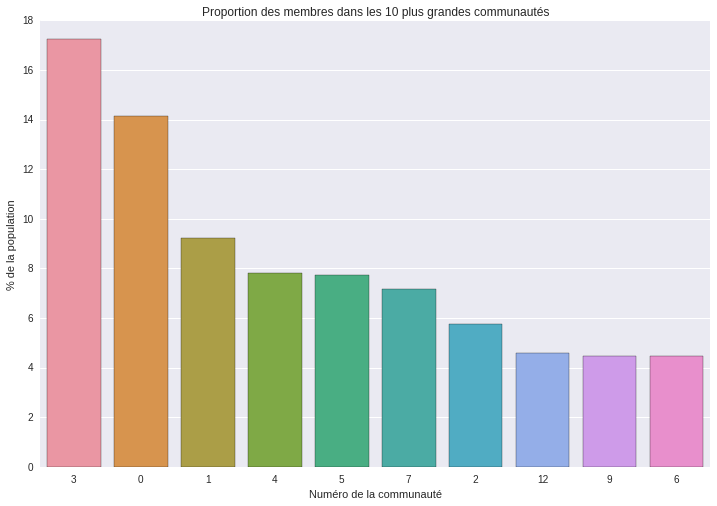

In [71]:
plt.figure(figsize=(12,8))

df_com = pd.DataFrame()
df_com["proportion"] = list_length
df_com["id"] = list_id

sns.barplot(x="id", y="proportion", data=df_com, order=list_id[:10])

plt.title("Proportion des membres dans les 10 plus grandes communautés")
plt.ylabel("% de la population")
plt.xlabel("Numéro de la communauté")


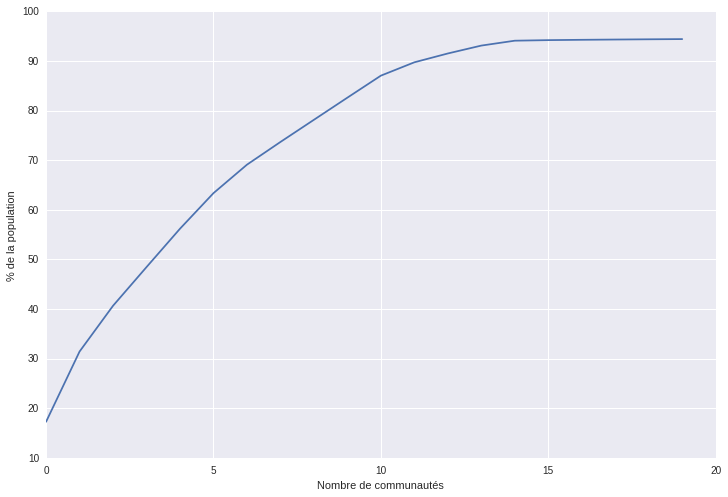

In [76]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(list_length[:20]))
plt.xlabel("Nombre de communautés")
plt.ylabel("% de la population")

In [73]:
array_colors = [ np.random.rand(3,1) for i in range(nb_communities)]

In [69]:
list_id_top_10 = [d["id_list"] for d in sorted_communities_list if d["id_community"] in list_id[:10]]
list_id_top_10 = [item for sublist in list_id_top_10 for item in sublist]

[32773, 32776, 32777, 32779, 37, 32814, 32816, 9, 32824, 32826, 32827, 63, 32837, 32838, 32852, 32877, 32884, 32888, 32889, 32895, 32898, 32899, 132, 135, 32908, 32909, 32910, 150, 32936, 32940, 32945, 32948, 31, 32956, 32970, 32979, 32994, 32995, 32996, 33012, 33014, 33016, 33017, 33020, 275, 33052, 33057, 33068, 33076, 33087, 33090, 33099, 33101, 33103, 33124, 366, 379, 33150, 385, 33156, 33166, 33171, 33174, 33195, 33199, 33223, 33234, 33250, 33255, 33257, 493, 33263, 33274, 33277, 33280, 33285, 33286, 33288, 33302, 33306, 33323, 33338, 33339, 33342, 578, 581, 33350, 33353, 33363, 603, 33376, 33392, 33406, 33420, 33426, 33429, 33430, 33441, 690, 33484, 733, 33509, 33511, 33518, 33532, 33538, 33543, 5, 33551, 33553, 33554, 33556, 33567, 804, 33578, 33586, 33588, 33599, 33601, 33607, 849, 33633, 33645, 33654, 33659, 33660, 33663, 33672, 33679, 33680, 33686, 33702, 33724, 33729, 33740, 33742, 979, 33749, 33755, 33767, 33769, 33796, 33807, 33808, 33809, 33815, 33833, 33834, 33851, 33878

CPU times: user 7min 22s, sys: 280 ms, total: 7min 22s
Wall time: 7min 22s


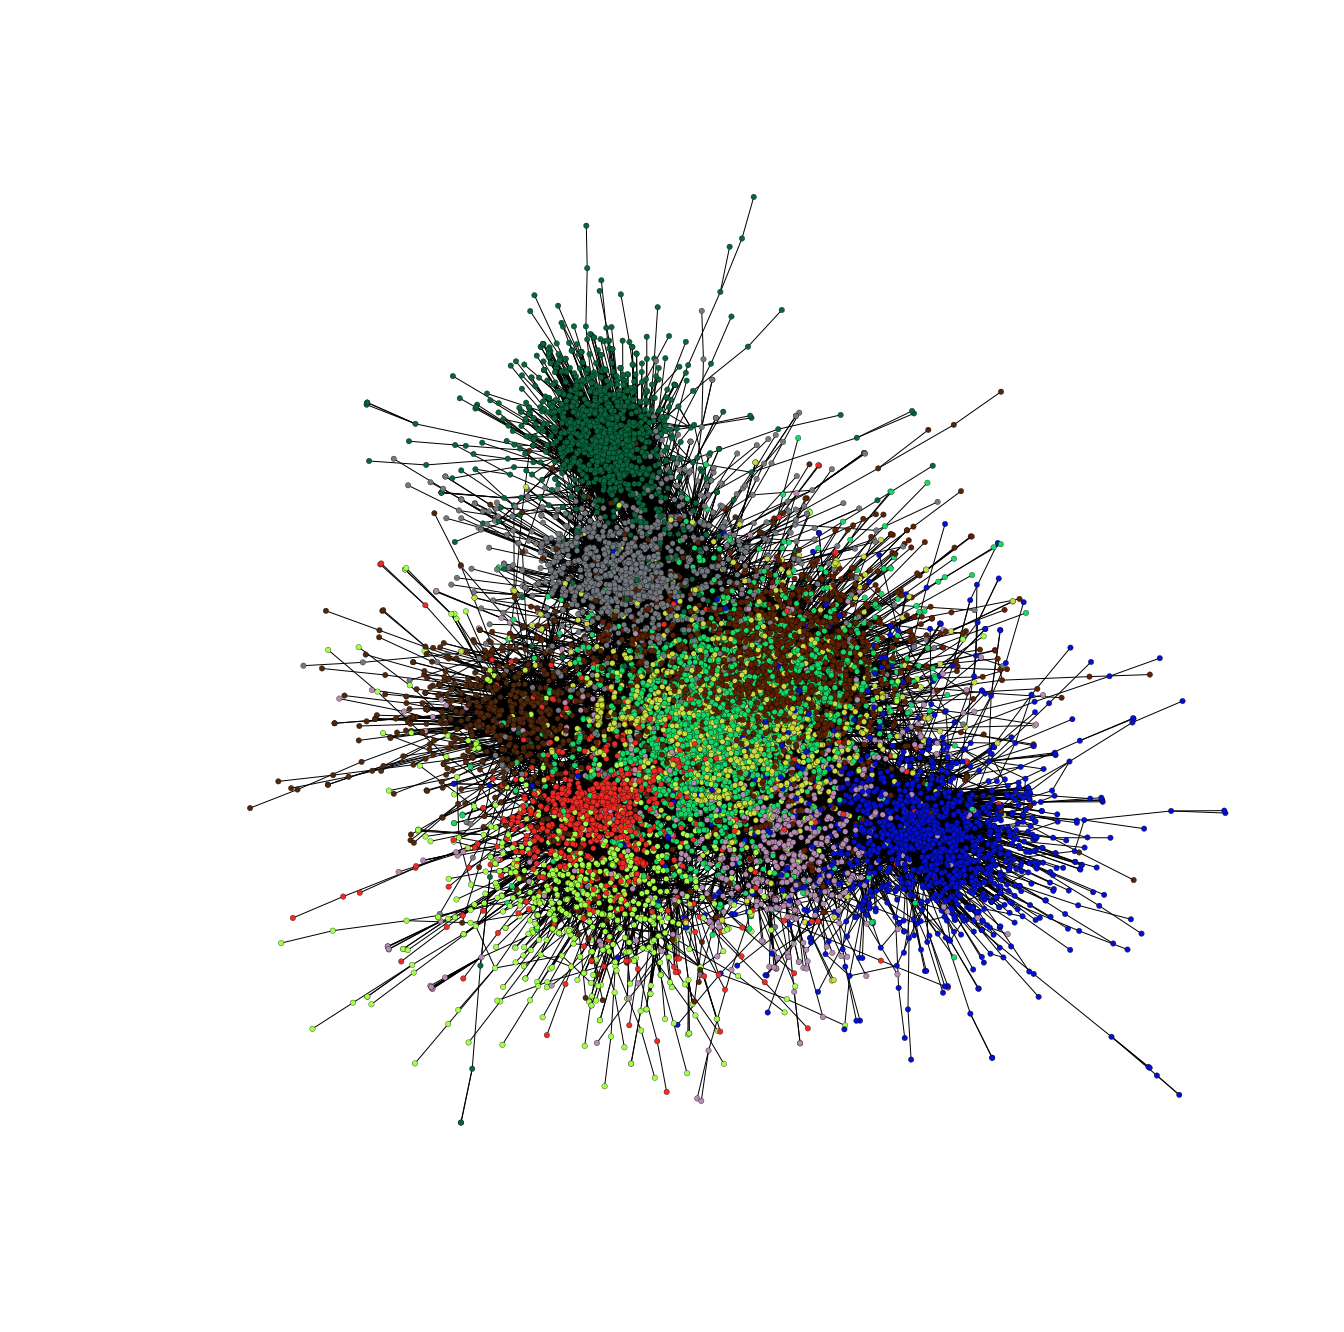

In [74]:
%%time

n_nodes = G.number_of_nodes()
subgraph = G.subgraph(list_id_top_10)

colors = []
for node, data in subgraph.nodes_iter(data=True):
    community = partition[node]
    colors.append(array_colors[community])
    
    '''
    if data["role"] == "client":
        colors.append("b")
    else:
        colors.append("r")
    '''
    
plt.figure(figsize=(18,18))
nx.draw_spring(subgraph, node_color=colors, node_size=30)



CPU times: user 10min 46s, sys: 572 ms, total: 10min 47s
Wall time: 10min 48s


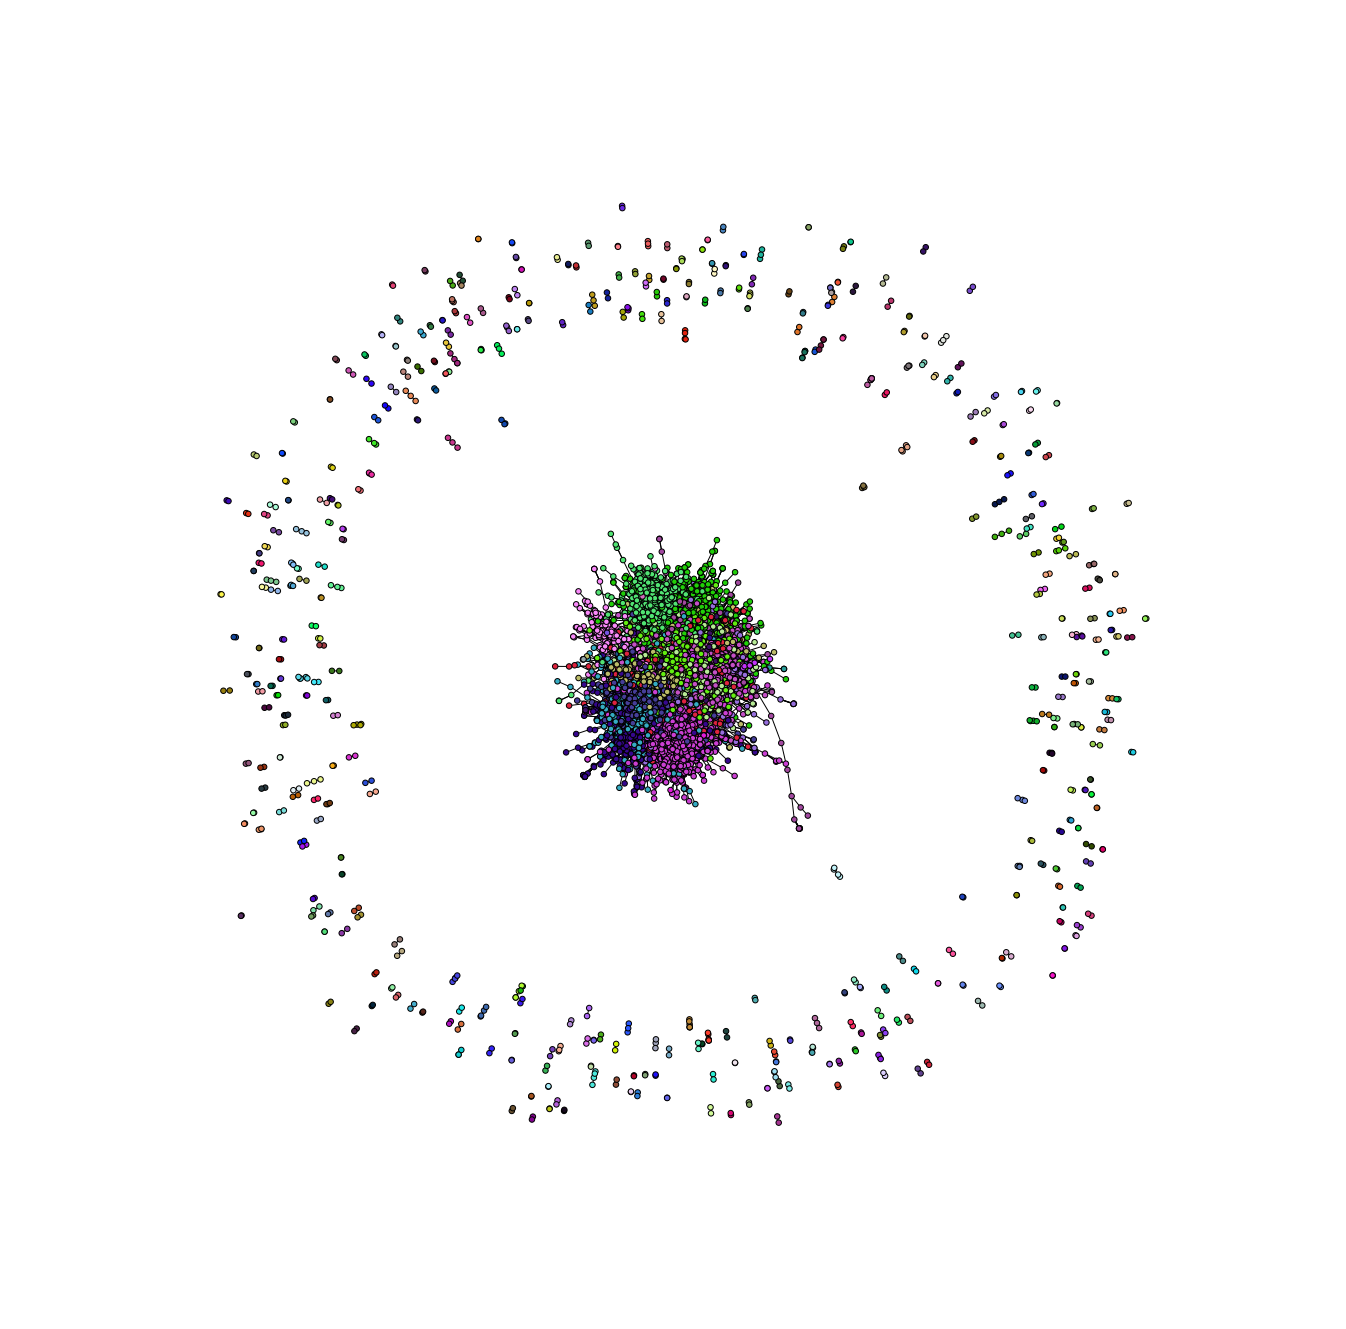

In [32]:
%%time

#Extract member from top 10 community
list_id = [d["id_community"] for d in sorted_communities_list]
list_length = [d["length"]/G.number_of_nodes() for d in sorted_communities_list]



n_nodes = G.number_of_nodes()
full_node_list = list(list_female_id) + list(list_male_id)
node_sample = random.sample(population=full_node_list, k=n_nodes)
subgraph = G.subgraph(node_sample)

colors = []
for node, data in subgraph.nodes_iter(data=True):
    community = partition[node]
    colors.append(array_colors[community])
    
    '''
    if data["role"] == "client":
        colors.append("b")
    else:
        colors.append("r")
    '''
    
plt.figure(figsize=(18,18))
nx.draw_spring(subgraph, node_color=colors, node_size=30)

